In [15]:
%pip install -q pandas scikit-learn joblib nltk

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

DATA_PATH = 'products_balanced.csv'
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
TFIDF_PATH = os.path.join(MODEL_DIR, 'tfidf_preprocessed.pkl')
LR_PATH = os.path.join(MODEL_DIR, 'lr_preprocessed.pkl')

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('products_balanced.csv')
df = df.dropna(subset=['query', 'category'])
df['category'] = df['category'].astype(str).str.strip()

print("Original category counts:")
print(df['category'].value_counts())

bath_indices = df[df['category'] == 'Bath & Shower'].index.tolist()
bath_half_indices = bath_indices[:len(bath_indices)//2]  # Take first half

skin_indices = df[df['category'] == 'Skin Care'].index.tolist()
skin_half_indices = skin_indices[:len(skin_indices)//2]  # Take first half

indices_to_update = bath_half_indices + skin_half_indices

df.loc[indices_to_update, 'category'] = 'Personal Care'
df = df[~((df['category'] == 'Bath & Shower') | (df['category'] == 'Skin Care'))]

print("\nNew category counts after merging half of each:")
print(df['category'].value_counts())

Original category counts:
category
Other                      1500
Skin Care                  1446
Bath & Shower              1446
Fragrance                  1427
Grocery & Gourmet Foods    1419
Hair Care                  1406
Detergents & Dishwash       582
Name: count, dtype: int64

New category counts after merging half of each:
category
Other                      1500
Personal Care              1446
Fragrance                  1427
Grocery & Gourmet Foods    1419
Hair Care                  1406
Detergents & Dishwash       582
Name: count, dtype: int64


Total number of products: 7780

Category Distribution:
--------------------------------------------------
Other: 1500 products (19.28%)
Personal Care: 1446 products (18.59%)
Fragrance: 1427 products (18.34%)
Grocery & Gourmet Foods: 1419 products (18.24%)
Hair Care: 1406 products (18.07%)
Detergents & Dishwash: 582 products (7.48%)

Summary Statistics:
Number of unique categories: 6
Most common category: Other (1500 products)
Least common category: Detergents & Dishwash (582 products)
Imbalance ratio (most common / least common): 2.58


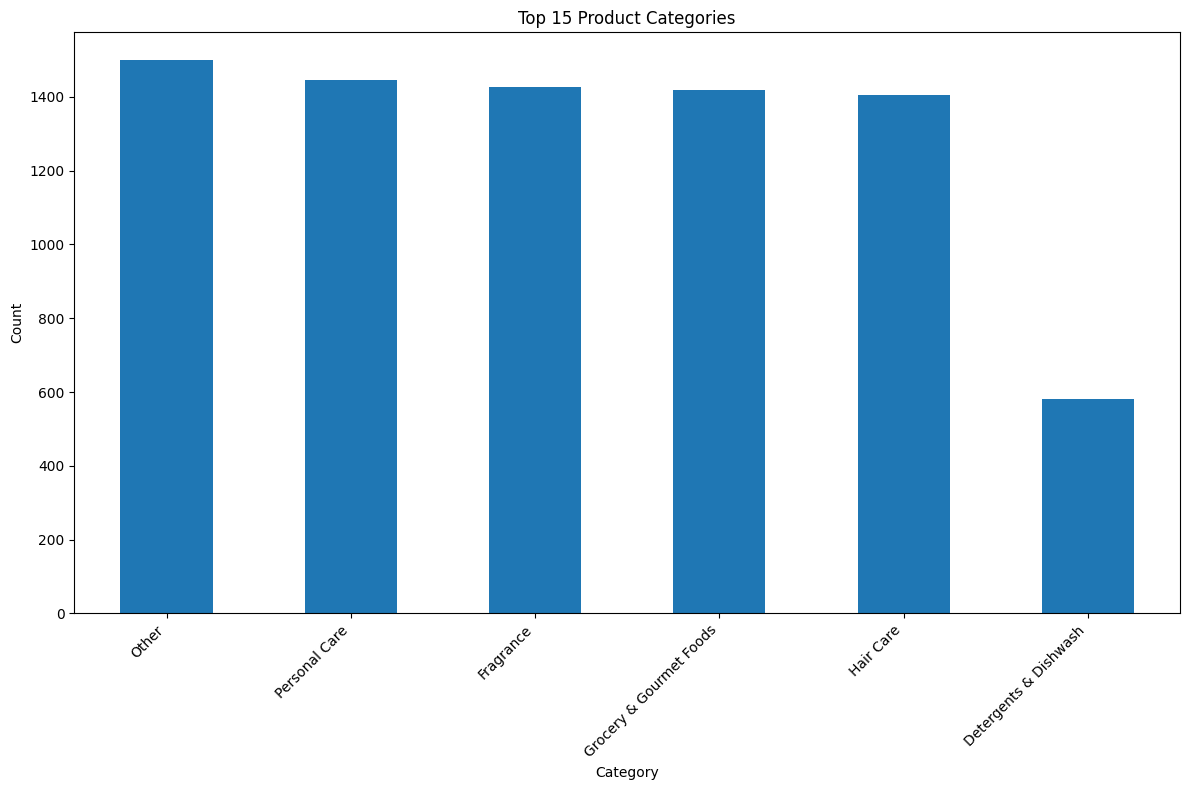

In [ ]:
import matplotlib.pyplot as plt

dfa = df.dropna(subset=['query', 'category'])
dfa['category'] = dfa['category'].astype(str).str.strip()

category_counts = dfa['category'].value_counts()
total_products = len(dfa)

print(f"Total number of products: {total_products}")
print("\nCategory Distribution:")
print("-" * 50)
for category, count in category_counts.items():
    percentage = (count / total_products) * 100
    print(f"{category}: {count} products ({percentage:.2f}%)")

print("\nSummary Statistics:")
print(f"Number of unique categories: {len(category_counts)}")
print(f"Most common category: {category_counts.index[0]} ({category_counts.iloc[0]} products)")
print(f"Least common category: {category_counts.index[-1]} ({category_counts.iloc[-1]} products)")
print(f"Imbalance ratio (most common / least common): {category_counts.iloc[0] / category_counts.iloc[-1]:.2f}")

plt.figure(figsize=(12, 8))
category_counts.head(15).plot(kind='bar')
plt.title('Top 15 Product Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
def clean_text(text):
    """Basic text cleaning"""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    """Remove stopwords"""
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

def lemmatize_text(text):
    """Lemmatize text"""
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_text(text):
    """Full preprocessing pipeline"""
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

In [ ]:
nltk.download('punkt_tab')
if not {'query','category'}.issubset(df.columns):
    raise ValueError('Dataset must contain columns: query, category')

df = df.dropna(subset=['query','category'])
df['category'] = df['category'].astype(str).str.strip()

print("Preprocessing queries...")
df['processed_query'] = df['query'].astype(str).apply(preprocess_text)

print("\nSample preprocessed data:")
for i, row in df[['query', 'processed_query', 'category']].head(3).iterrows():
    print(f"Original: '{row['query']}'")
    print(f"Processed: '{row['processed_query']}'")
    print(f"Category: {row['category']}\n")

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_query'], 
    df['category'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['category']
)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Preprocessing queries...

Sample preprocessed data:
Original: 'LAFCO New York Classic Reed Diffuser, Champagne - 6 oz - Up to 3 Months Fragrance Life - Reusable, Hand Blown Glass Vessel - Natural Wood Reeds - Made in The USA'
Processed: 'lafco new york classic reed diffuser champagne oz month fragrance life reusable hand blown glass vessel natural wood reed made usa'
Category: Fragrance

Original: 'Primal Elements Wax Melt, Pineapple Rum Splash, 2.5 Ounce'
Processed: 'primal element wax melt pineapple rum splash ounce'
Category: Fragrance

Original: 'Wind Song Dusting Powder for Women by Prince Matchabelli, 4 Ounce'
Processed: 'wind song dusting powder woman prince matchabelli ounce'
Category: Fragrance



In [14]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 3),  
        min_df=2,            
        max_df=0.9,          
        max_features=50000,
        sublinear_tf=True    
    )),
    ('lr', LogisticRegression(
        C=10,                
        solver='liblinear', 
        max_iter=2000, 
        class_weight='balanced'
    ))
])

print("Training model...")
pipe.fit(X_train, y_train)

print("\nEvaluating model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

joblib.dump(pipe.named_steps['tfidf'], TFIDF_PATH)
joblib.dump(pipe.named_steps['lr'], LR_PATH)
print(f'✅ Saved enhanced models to {MODEL_DIR}/')

Training model...


c:\Users\Nikhil\Downloads\New folder\myvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Evaluating model:
                         precision    recall  f1-score   support

  Detergents & Dishwash       0.89      0.84      0.86       116
              Fragrance       0.91      0.93      0.92       286
Grocery & Gourmet Foods       0.92      0.94      0.93       284
              Hair Care       0.89      0.91      0.90       281
                  Other       0.87      0.88      0.87       300
          Personal Care       0.84      0.80      0.82       289

               accuracy                           0.89      1556
              macro avg       0.89      0.88      0.88      1556
           weighted avg       0.89      0.89      0.89      1556

✅ Saved enhanced models to models/


In [16]:
def load_preprocessed_model():
    """Load the preprocessed model components"""
    tfidf = joblib.load(TFIDF_PATH)
    lr = joblib.load(LR_PATH)
    return tfidf, lr

def predict_with_preprocessing(query: str) -> str:
    """Predict category with preprocessing"""
    processed_query = preprocess_text(query)
    
    tfidf, lr = load_preprocessed_model()
    X = tfidf.transform([processed_query])
    return lr.predict(X)[0]

print("\nTesting predictions with preprocessing:")
test_queries = [
    "wireless earphones with floral scent", "LED bathroom mirror with lavender mist", "organic shampoo for cats and dogs", "eco-friendly floor cleaner with vitamin E", "smartphone sanitizer wipes", "herbal toothpaste for kitchen tiles", "green-tea scented fridge deodorizer", "bluetooth speaker bath bomb set", "solar-powered perfume diffuser", "coconut oil hair serum for laptops", "rose water facial toner for car interior", "anti-bacterial hand gel for TV screens", "mint-flavored floor cleaner tablets", "aloe vera body lotion for gaming chairs", "lavender essential oil plug-in air purifier"
]

for q in test_queries:
    try:
        category = predict_with_preprocessing(q)
        print(f"'{q}' -> {category}")
    except Exception as e:
        print(f"Error predicting for '{q}': {e}")


Testing predictions with preprocessing:
'wireless earphones with floral scent' -> Fragrance
'LED bathroom mirror with lavender mist' -> Personal Care
'organic shampoo for cats and dogs' -> Other
'eco-friendly floor cleaner with vitamin E' -> Detergents & Dishwash
'smartphone sanitizer wipes' -> Detergents & Dishwash
'herbal toothpaste for kitchen tiles' -> Other
'green-tea scented fridge deodorizer' -> Grocery & Gourmet Foods
'bluetooth speaker bath bomb set' -> Personal Care
'solar-powered perfume diffuser' -> Fragrance
'coconut oil hair serum for laptops' -> Hair Care
'rose water facial toner for car interior' -> Other
'anti-bacterial hand gel for TV screens' -> Personal Care
'mint-flavored floor cleaner tablets' -> Detergents & Dishwash
'aloe vera body lotion for gaming chairs' -> Personal Care
'lavender essential oil plug-in air purifier' -> Fragrance
